In [2]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


In [3]:
# GET DataSet
# Keras에 있는 것 그냥 가져올 것

fashion_mnist = tf.keras.datasets.fashion_mnist

(train_x, _), (test_x, _) = fashion_mnist.load_data()#언더스코어(_)는 값을 무시

In [4]:
# 가져온 데이터 픽셀 범위 확인
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [5]:
# 정규화를 해보자.
train_x = (train_x - 127.5)/127.5 # 이미지를 [-1, 1]로 정규화

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


정규화를 통해 픽셀 범위를 -1.0 ~1.0으로 만들었다.

In [6]:
# shape 확인
train_x.shape

(60000, 28, 28)

60000개의 28x28사이즈의 데이터가 있다.

딥러닝에서 이미지를 다루려면 채널 수에 대한 Dimention이 필요하다.  
Gray scale이므로 shape에 채널 값 1을 넣어주겠다.

In [7]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

채널 값이 들어갔음을 확인한다.

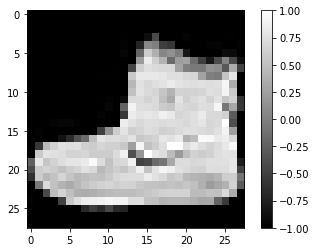

In [8]:
# plt로 시각화 체크
plt.imshow(train_x[0].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

나이키 하이탑 슈즈인가??  
index 0의 이미지는 슈즈인것 같다.  

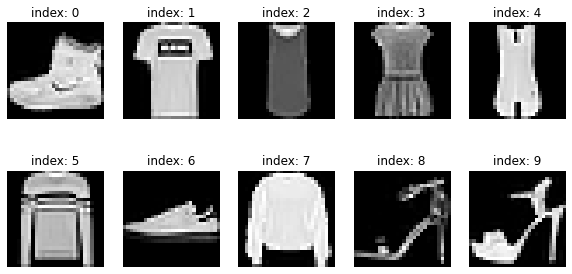

In [9]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

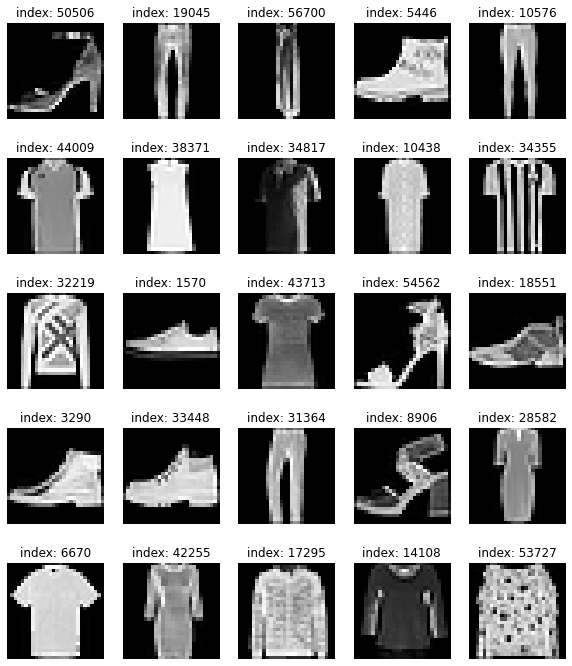

In [10]:
# 이미지 25개를 5x5의 배열로 띄우기, 추출은 랜덤으로.
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5,5, i+1)
    randIdx = np.random.randint(1,60000)
    plt.imshow(train_x[randIdx].reshape(28,28), cmap='gray')
    plt.title(f'index: {randIdx}')
    plt.axis('off')
    
plt.show()

데이터의 양이 많기때문에 미니배치를 실시한다.

In [11]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Making a Generator
GAN보다 발전된 DCGAN을 쓸 것이다. 
모델 구현은 Keras Sequential API를 활용

In [14]:
#모델 구현
def make_generator_model():
    
    #Start
    model = tf.keras.Sequential()
    
    #First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    #Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))
    
    #Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5,5), strides=(1,1),padding='same',use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    #Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5,5), strides=(2,2),padding='same',use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    #Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5,5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

Conv2DTranspose레이어를 사용했는데 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층이다.  
이 모델에서는 세번의 Conv2DTranspose 층을 이용해 (7, 7, 256) -> (14, 14, 64) -> (28, 28, 1)  
순으로 이미지를 키워 나가고, 최종적으로 (28, 28, 1)사이즈


In [15]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터 만들기

In [16]:
noise = tf.random.normal([1, 100])

In [17]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

 [1, 28, 28, 1]사이즈의 이미지 생성 (1은 배치 사이즈, 나머지는 이미지 사이즈)

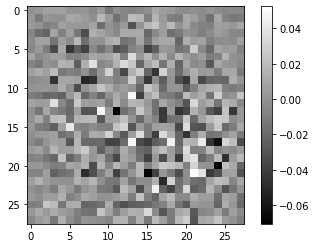

In [19]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

-1 과 1 사이의 값에서 적당히 잘 생성됨을 확인( 아직 모델 학습 전이라 의미없는 노이즈가 생성됐다.)

## Making a Discrimnator

In [22]:
#판별자 함수 구현
def make_discriminator_model():
    
    #start
    model = tf.keras.Sequential()
    
    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

Conv2DTranspose층을 사용한 것과 반대로, 판별자는 Conv2D층으로 이미지의 크기를 점점 줄여나간다.  
입력된 [28, 28, 1]사이즈의 이미지는 다음 층을 거치며 (28, 28, 1)->(14,14,64)->(7,7,128)까지 줄어든다.  
마지막에는 Flatten으로 3차원 이미지를 1차원을 쭉 펴서 7x7x128=6272, 즉(1,6271)형상의 벡터로 변환한다.  
이는 생성자의 Reshape이 1차원 벡터를 3차원 벡터로 바꿨는데 이는 반대로 1차원 벡터로 변환시킨다.  
그리고 Dense 레이어를 거쳐 하나의 출력 값을 내놓는다.

In [23]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

아까 만들었던 임시 가짜 이미지를 판별자에 넣어보자.

In [24]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00030929]], dtype=float32)>

텐서플로우의 텐서 형태로 출력했다.

손실함수 적용
...

In [25]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)
real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)


 tf.ones_like()와 tf.zeros_like() 함수를 활용하면  
 특정 벡터와 동일한 크기이면서 값은 1또는 0으로 가득 채워진 벡터로 만든다.

In [26]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

- generator_loss  
generator_loss는 fake_output가 1에 가까워지기를 바라므로, 다음과 같이 tf.ones_like와의 교차 엔트로피값을 계산하면 됩니다.
즉, cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가집니다.


In [27]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

- discriminator_loss
discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산합니다. real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교하면 되겠죠!



In [28]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss